In [1]:
# Import libraries
import os
import pickle
from itertools import combinations
import numpy as np
from numpy.linalg import norm
import scipy.stats as stats
import MDAnalysis as mda
import mdtraj as mdt
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D
import bayesaxs as bs

/home/kausasm/anaconda3/envs/bayesaxs/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Helper functions

In [2]:
def load_dat(path_to_dat, skiprows=0):
    """ Load scattering .dat file."""
    
    dat = np.loadtxt(path_to_dat)
    q = dat[:,0]
    iq = dat[:,1]
    sigma = dat[:,2]
    
    return q, iq, sigma

In [3]:
def get_fit(path_to_fit, skiprows):
    """ Get scattering column from the .fit file."""
    data = np.loadtxt(path_to_fit, skiprows=skiprows)
    fit = data[:,3] 
    return fit

#### Figure 1A

<ipython-input-4-11e07162b3c4>:16: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.semilogy(nonposy="clip")


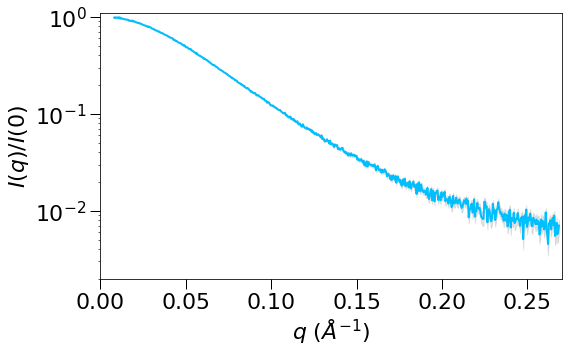

In [4]:
fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

marker_style = dict(marker='o', s=25, alpha=0.2, edgecolors="tab:red")
tick_params = dict(labelsize=fs, length=10, width=1)

ax.plot(q, iq, color="deepskyblue", linewidth=2, zorder=2)
ax.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=0.2, zorder=1)

ax.semilogy(nonposy="clip")

ax.set_xlim(0, 0.27)
ax.set_ylim(0.002, 1.1)

ax.tick_params(**tick_params)

ax.set_xlabel("$q$ $(\AA^{-1})$", fontsize=fs)
ax.set_ylabel('$I(q)/I(0)$', fontsize=fs)

plt.tight_layout()

#### Figure 1B

In [5]:
def normalized_kratky(q, iq, i0, rg):
    """ Normalized Kratky function."""
    return ((q * rg) ** 2) * iq/i0 

def guinier_approximation(x):
    """ Guinier approximation for a spherical particle."""
    return x ** 2 * np.exp(-x ** 2/3)

def gaussian_chain_approximation(x):
    """ Guinier approximation for a spherical particle."""
    return (2 / x ** 2) * (np.exp(-x**2) + x**2 - 1)

<ipython-input-5-f2f5f004e726>:11: RuntimeWarning: divide by zero encountered in true_divide
  return (2 / x ** 2) * (np.exp(-x**2) + x**2 - 1)
<ipython-input-5-f2f5f004e726>:11: RuntimeWarning: invalid value encountered in multiply
  return (2 / x ** 2) * (np.exp(-x**2) + x**2 - 1)


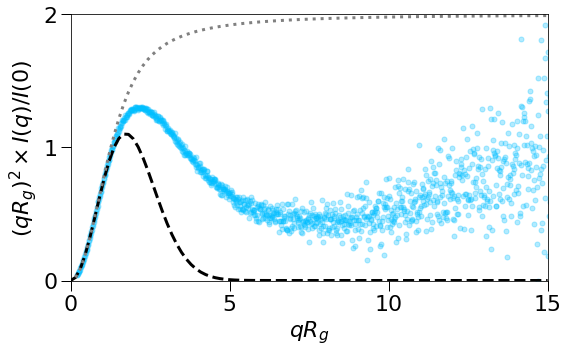

In [6]:
fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

marker_style = dict(marker='o', s=25, alpha=0.3)
tick_params = dict(labelsize=fs, length=10, width=1)

i0 = 0.015
rg = 30.33
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS_full.dat", skiprows=0)

ax.scatter(q * rg, normalized_kratky(q, iq, i0, rg), color="deepskyblue", **marker_style)

ax.plot(np.linspace(0, 15, 100), guinier_approximation(np.linspace(0, 15, 100)),
    zorder=2,
    linewidth=3,
    linestyle="--",
    color="k")

ax.plot(np.linspace(0, 15, 100), gaussian_chain_approximation(np.linspace(0, 15, 100)),
    zorder=2,
    linewidth=3,
    linestyle=":",
    color="grey")

ax.set_xlim(0,15)
ax.set_ylim(0, 2)

ax.set_xticks([0, 5, 10, 15])
ax.set_yticks([0, 1, 2])

ax.tick_params(**tick_params)

ax.set_xlabel("$qR_g$", fontsize=fs)
ax.set_ylabel("$(qR_g)^2 \\times I(q)/I(0)$", fontsize=fs)

plt.tight_layout()

#### Figure 1C

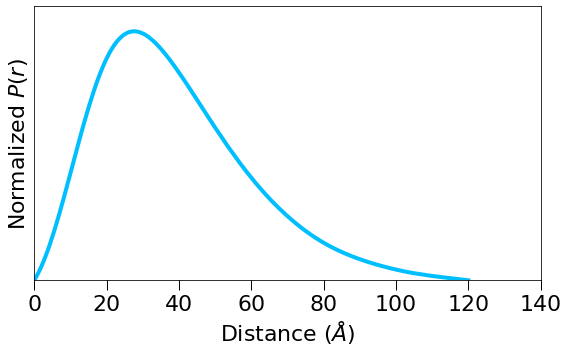

In [7]:
fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

tick_params = dict(labelsize=fs, length=10, width=1)

rbr_pr = np.loadtxt("experimental_data/HOIP_Pr_distribution.out", skiprows=1)
r = rbr_pr[:,0]
p = rbr_pr[:,1]

ax.plot(r, p / p.max(), linewidth=4, color="deepskyblue")

ax.set_xlim(0,140)
ax.set_ylim(0, 1.1)

ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
ax.set_yticks([])

ax.tick_params(**tick_params)

ax.set_xlabel("Distance $(\AA)$", fontsize=fs)
ax.set_ylabel("Normalized $P(r)$", fontsize=fs)

plt.tight_layout()

#### Figure 3A

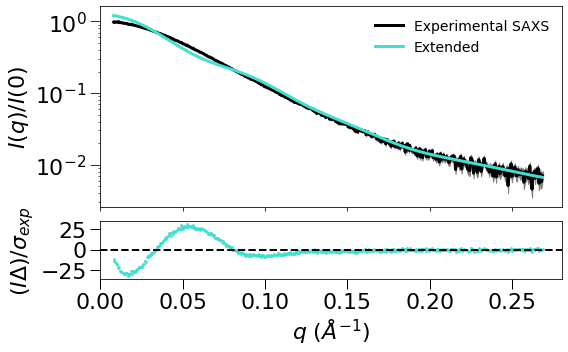

In [8]:
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_extended = get_fit("MD_ensemble/scattering_profiles/HOIP_extended.fit", skiprows=0)
fit_extended = fit_extended / i0

residuals_extended = (iq - fit_extended) / sigma

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

ax1.plot(q, fit_extended, color="turquoise", alpha=1, linewidth=3, label="Extended")

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)

ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

ax2.scatter(q, residuals_extended, s=3, color="turquoise", zorder=1, marker='o', alpha=1)
    
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

plt.tight_layout()

#### Figure 3B

In [9]:
def domain_dist(domains, domain1, domain2):
    """ Calculate distance between COM of two RBR subdomains. Helper function of calculate_RBR_dist()."""

    cm = dict((name, dom.center_of_mass()) for name, dom in domains.items())

    return np.linalg.norm(cm[domain1] - cm[domain2])

def calculate_RBR_dist(top):
    """ Calculate distance between RING1-IBR and IBR-RING2 domains using their COM for a trajectory."""

    # Initialize the system
    u = mda.Universe(top)

    # Defined domains for three RBR subdomains as a dict
    domains = {
        'RING1': u.select_atoms("resid 699:751 and (backbone or name CB)"),
        'IBR': u.select_atoms("resid 797:841 and (backbone or name CB)"),
        'RING2': u.select_atoms("resid 869:935 and (backbone or name CB)")}

    # Distances (d1, d2, d3) to be stored in an numpy array
    d1d2_distances = np.array([(domain_dist(domains, "RING1", "IBR"), domain_dist(domains, "IBR", "RING2")) for ts in u.trajectory])

    return d1d2_distances[0]

In [10]:
def compute_distances_for_MD_cluster_labels(labels):
    """ Compute interdomain distances for selected cluster labels."""
    parameters = {}
    for i, label in enumerate(labels):
        parameters[i + 1] = calculate_RBR_dist("MD_ensemble/MD_clusters/cluster_leader_{}.pdb".format(label))
    return parameters

In [11]:
# Compute distances for representative MD cluster labels
representative_md_cluster_labels = [3, 1, 2, 21, 86, 163]
distances_md = compute_distances_for_MD_cluster_labels(labels=representative_md_cluster_labels)

In [12]:
def get_histogram(xval, yval, nbins=100):
    """ Compute a 2D histogram."""
    z, xedge, yedge = np.histogram2d(xval, yval, bins=nbins)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    
    return z.T, x, y 

def density(z):
    """ Normalize density."""
    return z / float(z.sum())

def free_energy(z):
    """ Compute a negative log of the density values."""
    prob = density(z)
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = prob.nonzero()
    free_energy[nonzero] = -np.log(prob[nonzero])
    
    return free_energy

def prepare_two_cvs(cv1, cv2, bins, weights=None):
    """ Prepare CVs for plotting."""
    
    # Define range of collective variables
    xmin = np.floor(cv1.min())
    xmax = np.ceil(cv1.max())
    ymin = np.floor(cv2.min())
    ymax = np.ceil(cv2.max())

    # Calculate bin size for each collective variable
    xbin_size = (xmax - xmin) / bins
    ybin_size = (ymax - ymin) / bins
    xedges = np.arange(xmin, xmax, xbin_size)
    yedges = np.arange(ymin, ymax, ybin_size)

    # Histogram values into 2D array
    H, xedges, yedges = get_histogram(cv1, cv2, bins)
    f = free_energy(H)

    return f, xedges, yedges


def plot_2D_contour(H, xedges, yedges, cv1, cv2, labels_dict):
    """ Plot 2D FES contour plot."""
    
    fs = 22
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(111)
    
    H -= H.min()
    m = H[np.isfinite(H)].max()
    
    contour = ax.contourf(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="Spectral", # GnBu_r
                         levels=np.linspace(0, int(np.round(m)), int(np.round(m) * 2 + 1)),
                         corner_mask=True,
                         alpha=0.75)
    cbar = fig.colorbar(contour, ax = ax)
    cbar.ax.tick_params(labelsize=fs)
    cbar.ax.set_ylabel("$-\ln P$ MD", fontsize=fs)
    
    contour = ax.contour(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="gist_gray",
                         levels=np.linspace(0, int(np.round(m)), int(np.round(m) * 2 + 1)),
                         linewidths=1,
                         corner_mask=True,
                         alpha=1)
    
    ax.plot(cv1[0], cv2[0], 'o', markersize=25, color="tab:orange", markeredgewidth=1, markeredgecolor='k')
    ax.plot(cv1[0], cv2[0], 'x', markersize=18, color="tab:orange", fillstyle="none", markeredgewidth=1, markeredgecolor='k')
    
    for key in labels_dict.keys():
        
        x = labels_dict[key][0]
        y = labels_dict[key][1]

        ax.plot(x, y, 'o', markersize=15, color="w", markeredgewidth=3, markeredgecolor='k')
        ax.annotate(key,
                 (x, y),
                 xytext=(4, 6),
                 textcoords='offset points',
                 fontsize=20,
                 weight="bold")
        
    ax.tick_params(labelsize=fs)
    
    ax.set_xlabel("$D_{R1-IBR}$ $(\AA)$", fontsize=fs)
    ax.set_ylabel("$D_{IBR-R2}$ $(\AA)$", fontsize=fs)
    
    fig.tight_layout()


def two_variable_contour(cv1, cv2, bins, labels_dict, weights=None):
    """ Plot a 2D FES contour for two CVs."""
    
    # Check if the weights are provided
    if weights is not None:
        weights = load_weights(weights)

    H, xedges, yedges = prepare_two_cvs(cv1, cv2, bins, weights=weights)
    plot_2D_contour(H, xedges, yedges, cv1, cv2, labels_dict)

    return

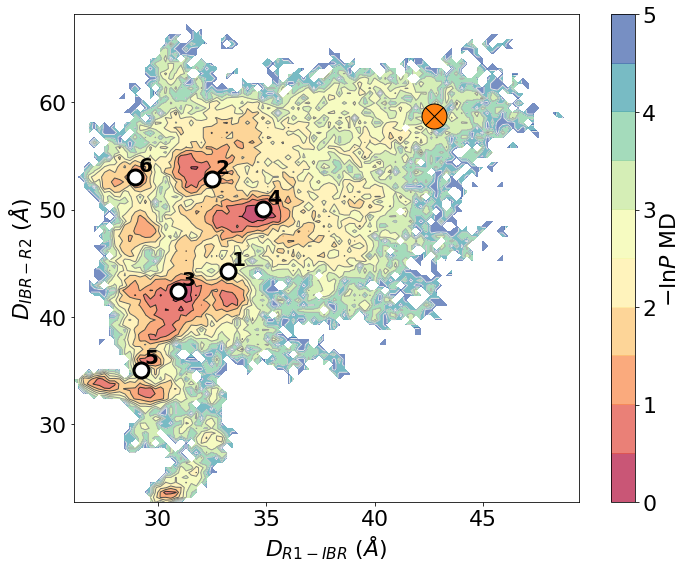

In [13]:
cv1 = np.loadtxt("MD_ensemble/MD_collective_variables/d1.txt")
cv2 = np.loadtxt("MD_ensemble/MD_collective_variables/d2.txt")
two_variable_contour(cv1=cv1, cv2=cv2, bins=100, labels_dict=distances_md)  

#### Figure 3D

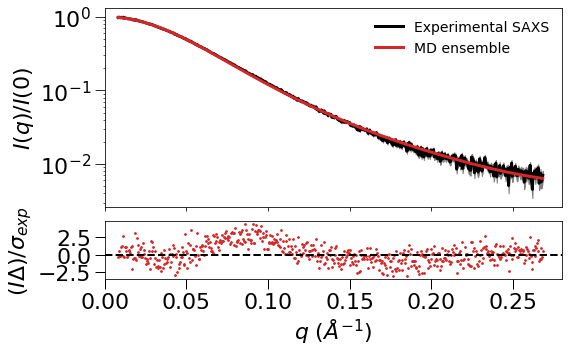

In [14]:
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MD_ensemble/scattering_profiles/HOIP_extended_combined_MD_simulations_1us.fit", skiprows=0)
fit_md = fit_md / i0

residuals_md = (iq - fit_md) / sigma

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

ax1.plot(q, fit_md, color="tab:red", alpha=1, linewidth=3, label="MD ensemble")

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)

ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

ax2.scatter(q, residuals_md, s=3, color="tab:red", zorder=1, marker='o', alpha=1)
    
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

plt.tight_layout()

#### Figure 3E

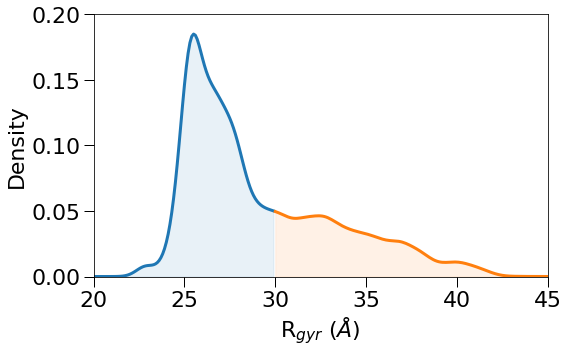

In [5]:
tick_params = dict(labelsize=22, length=10, width=1)

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")
density = stats.kde.gaussian_kde(rgyr)
x = np.arange(20, 50, .1)

ax.plot(x[x < 30.0],
        density(x)[x < 30.0],
        color="tab:blue",
        linewidth=3)
ax.plot(x[x > 30.0],
        density(x)[x > 30.0],
        color="tab:orange",
        linewidth=3)
ax.fill_between(x[x < 30.0],
                density(x)[x < 30.0],
                color="tab:blue",
                alpha=0.1)
ax.fill_between(x[x > 30.0],
                density(x)[x > 30.0],
                color="tab:orange",
                alpha=0.1)

ax.set_xlim(20, 45)
ax.set_ylim(0, 0.2)
ax.tick_params(**tick_params)

ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])

ax.set_xlabel(r'R$_{gyr}$ ($\AA$)', fontsize=fs)
ax.set_ylabel(r'Density', fontsize=fs)

plt.tight_layout()

plt.savefig("figure_3_subpanel_E.png", dpi=600)

#### Figure 3F

In [16]:
def prepare_three_cvs(cv1, cv2, cv3, bins, weights):
    """ Prepare input for FES (2 CVs) and Contour(1 CV) plot."""
    
    ## Generate a 2D histogram of first two collective variables
    # Define range of collective variables
    xmin = np.floor(cv1.min())
    xmax = np.ceil(cv1.max())
    ymin = np.floor(cv2.min())
    ymax = np.ceil(cv2.max())

    # Calculate bin size for each collective variable
    xbin_size = (xmax - xmin) / bins
    ybin_size = (ymax - ymin) / bins
    xedges = np.arange(xmin, xmax, xbin_size)
    yedges = np.arange(ymin, ymax, ybin_size)

    # Histogram values into 2D array
    H, xedges, yedges = np.histogram2d(cv1, cv2, bins=(xedges, yedges), weights=weights, normed=True)
    
    ## Generate a 2D histogram for the third collective variable
    # Stack collective variables
    stacked_cvs = np.vstack((cv1, cv2, cv3)).T

    # Create zeros arrays
    value_mat = np.zeros(H.shape)
    density_mat = np.zeros(H.shape)

    # Calculate a normalized count matrix of a third collective variable
    for indx, row in enumerate(stacked_cvs):
        scv1 = row[0]
        scv2 = row[1]
        scv3 = row[2]

    # Bin positions for indexing
        scv1_bin_indx = np.where((xedges <= scv1) == True)[0][-1] - 1
        scv2_bin_indx = np.where((yedges <= scv2) == True)[0][-1] - 1

        value_mat[scv1_bin_indx, scv2_bin_indx] += scv3
        density_mat[scv1_bin_indx, scv2_bin_indx] += 1

    J = np.divide(value_mat, density_mat)

    return -np.log(H.T), J.T, xedges, yedges


def plot_contour(H, J, xedges, yedges):
    """ Helper plotting function."""
    
    fs = 22
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(111)
    
    top = cm.get_cmap('Blues_r', 128)
    bottom = cm.get_cmap('Oranges', 128)

    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                           bottom(np.linspace(0, 1, 128))))
    newcmp = ListedColormap(newcolors, name='OrangeBlue')
    
    imshow = ax.imshow(J, interpolation='nearest',
                       origin='lower',
                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect="auto", cmap=newcmp)
    cbar = fig.colorbar(imshow, ax = ax)
    cbar.set_ticks([25, 30, 35, 40])
    cbar.ax.tick_params(labelsize=fs)
    cbar.ax.set_ylabel("$R_g$ $(\AA)$", fontsize=fs)
    
    ax.tick_params(labelsize=fs)
    
    ax.set_xlabel("$D_{R1-IBR}$ $(\AA)$", fontsize=fs)
    ax.set_ylabel("$D_{IBR-R2}$ $(\AA)$", fontsize=fs)
    
    fig.tight_layout()


def three_variable_contour(cv1, cv2, cv3, bins, weights=None):
    """ Plot a 2D contour FES plot with an overlay of count matrix."""

    # Check if the weights are provided
    if weights is not None:
        weights = load_weights(weights)

    H, J, xedges, yedges = prepare_three_cvs(cv1, cv2, cv3, bins, weights=weights)
    plot_contour(H, J, xedges, yedges)

    return

<ipython-input-16-30725c9d13c4>:41: RuntimeWarning: invalid value encountered in true_divide
  J = np.divide(value_mat, density_mat)
<ipython-input-16-30725c9d13c4>:43: RuntimeWarning: divide by zero encountered in log
  return -np.log(H.T), J.T, xedges, yedges


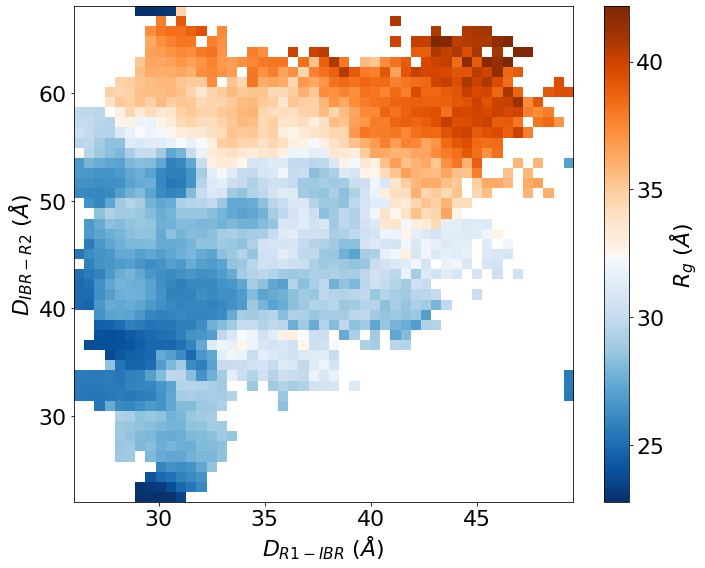

In [17]:
cv1 = np.loadtxt("MD_ensemble/MD_collective_variables/d1.txt")
cv2 = np.loadtxt("MD_ensemble/MD_collective_variables/d2.txt")
cv3 = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")
three_variable_contour(cv1=cv1, cv2=cv2, cv3=cv3,bins=50)

#### Figure 3G

In [18]:
i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_below_30 = np.loadtxt("MD_ensemble/scattering_profiles/HOIP_extended_combined_MD_simulations_1us_below_30_rgyr.fit", skiprows=0)[:,1]
fit_below_30 = fit_below_30 / i0
fit_above_30 = np.loadtxt("MD_ensemble/scattering_profiles/HOIP_extended_combined_MD_simulations_1us_above_30_rgyr.fit", skiprows=0)[:,1]
fit_above_30 = fit_above_30 / i0
fits = [fit_below_30, fit_above_30]

residuals_below_30 = (iq - fit_below_30) / sigma
residuals_above_30 = (iq - fit_above_30) / sigma
residuals = [residuals_below_30, residuals_above_30]

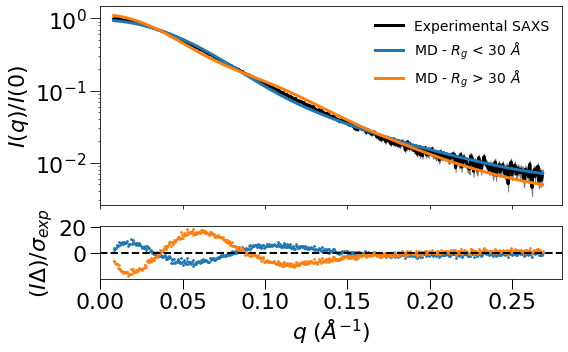

In [19]:
# Plot a fit between experimental and theoretical scattering data
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD - $R_g$ < 30 $\AA$", "MD - $R_g$ > 30 $\AA$"]
colors=["tab:blue", "tab:orange"]
selected_ids = [0, 1]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
    
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

plt.tight_layout()

#### Figure 4A

In [20]:
states = bs.load_pickle("MaxPars_ensemble/HOIP_extended_basis_set.pkl")
states

{'182:184:86:149:227:281:44:143': {'wopt': array([0.0105955 , 0.00349829, 0.43872833, 0.00067259, 0.18072769,
         0.10880706, 0.25528143, 0.00168912]),
  'sd': array([0.00891898, 0.00284686, 0.00703797, 0.00104415, 0.02756569,
         0.01713909, 0.03664073, 0.00160479]),
  'opt_curve': Curve: opt_curve,
  'opt_chi2red': 1.473713747738706,
  'trace': <MultiTrace: 1 chains, 50000 iterations, 2 variables>}}

In [21]:
# Prepare name mapping for plotting
name_mapping = {182: 1,
               184: 2,
               86: 3,
               149: 4,
               227: 5,
               281: 6,
               44: 7,
               143: 8}

# Define cluster names and colors
clusts = [1, 2, 3, 4, 5, 6, 7, 8]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:olive"]

# Prepare color mapping
color_mapping = {1: "tab:blue",
                2: "tab:orange",
                3: "tab:green",
                4: "tab:red",
                5: "tab:purple",
                6: "tab:brown",
                7: "tab:pink",
                8: "tab:olive"}

/home/kausasm/Documents/papers.data/version_2/supplementary_data/bayesaxs/viz/plotting.py:88: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.semilogy(nonposy="clip")


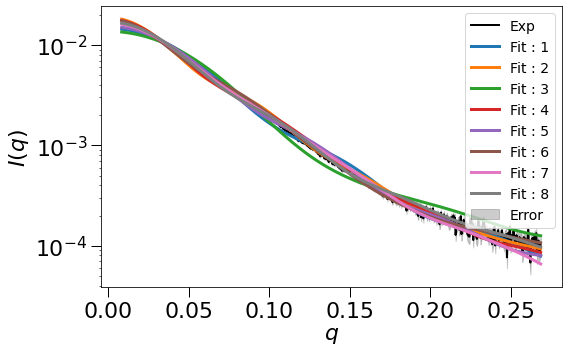

In [22]:
analysis = bs.Scatter()
analysis.load_representative_fits("MaxPars_ensemble/HOIP_extended_repfits/")
repfits = analysis.get_representative_fits()
for repfit in repfits:
    title = int(repfit.get_title())
    new_title = name_mapping[title]
    repfit.set_title(new_title)
bs.plot_multiple_fits(repfits)
plt.tight_layout()

#### Figure 4B

/home/kausasm/Documents/papers.data/version_2/supplementary_data/bayesaxs/viz/plotting.py:50: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.semilogy(nonposy="clip")


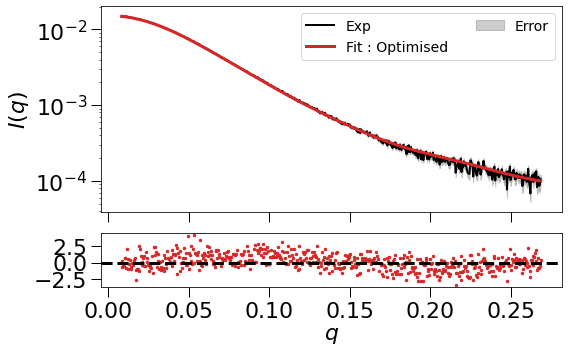

In [23]:
# Visualise the scatter
opt_curve = states['182:184:86:149:227:281:44:143']["opt_curve"]
opt_curve.set_title("Optimised")
bs.plot_single_fit(opt_curve)
plt.tight_layout()

#### Figure 4C

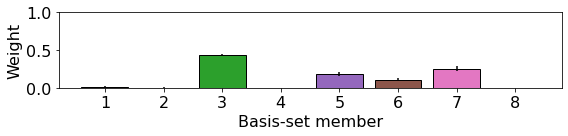

In [24]:
tick_params = dict(labelsize=22, length=10, width=1)

# Parse results
comb = '182:184:86:149:227:281:44:143'
clusters = comb.split(":")
w = states[comb]["wopt"]
sd = states[comb]["sd"]

# Plot weights
fs = tick_params["labelsize"]
fig = plt.figure(figsize=[8, 2])
ax = fig.add_subplot(111)

ax.bar(clusts, w, yerr=sd, color=colors, edgecolor="black")
ax.set_ylim(0, 1)
ax.set_xlabel("Basis-set member", fontsize=fs - 6)
ax.set_ylabel("Weight", fontsize=fs - 6)
ax.tick_params(labelsize=fs - 6)

plt.tight_layout()

#### Figure 5A

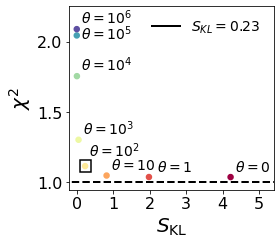

In [25]:
fs = 20
fig = plt.figure(figsize=[4, 3.5])
ax = fig.add_subplot(111)

theta = 100

chi2_skl = np.loadtxt("MaxEnt_ensemble/output.files/chi2_skl.txt")

scatter = ax.scatter(chi2_skl[:,1], chi2_skl[:,0],
            marker='o',
            s=20,
            c=np.arange(8),
            facecolors="none",
            linewidths=2,
            cmap="Spectral")

labels = ["$\\theta = 10^6$",
          "$\\theta = 10^5$",
          "$\\theta = 10^4$",
          "$\\theta = 10^3$",
          "$\\theta = 10^2$", 
          "$\\theta = 10$",
          "$\\theta = 1$",
          "$\\theta = 0$"][::-1]

for idx, point in enumerate(chi2_skl):
        
        x = point[1]
        y = point[0]
        
        if labels[idx] == "$\\theta = 10^5$":
            ax.annotate(labels[idx],
                     (x, y),
                     xytext=(4, -4),
                     textcoords='offset points',
                     fontsize=14)
        
        elif labels[idx] == "$\\theta = 10^2$":
            ax.annotate(labels[idx],
                     (x, y),
                     xytext=(4, 10),
                     textcoords='offset points',
                     fontsize=14)
        
        elif labels[idx] == "$\\theta = 1$":
            ax.annotate(labels[idx],
                     (x, y),
                     xytext=(8, 6),
                     textcoords='offset points',
                     fontsize=14)
        
        else:
            ax.annotate(labels[idx],
                     (x, y),
                     xytext=(4, 6),
                     textcoords='offset points',
                     fontsize=14)
        
theta_idx = 3
        
x_side = 0.3
y_side = 0.08
rect = matplotlib.patches.Rectangle((chi2_skl[theta_idx:theta_idx + 1, 1] - x_side / 2,
                                    chi2_skl[theta_idx:theta_idx + 1, 0] - y_side / 2),
                                    x_side, 
                                    y_side,
                                    linewidth=1.5,
                                    edgecolor='k',
                                    facecolor='none')
ax.add_patch(rect)

plt.hlines(1, -1, 10, linewidths=2, linestyle="--", color="k")

ax.set_xlabel(r'$S_{\mathrm{KL}}$', fontsize=fs)
ax.set_ylabel(r'$\chi^{2}$', fontsize=fs)

ax.set_xlim(-0.2, 5.4)
ax.set_ylim(0.95, 2.25)

ax.tick_params(labelsize=16)

ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_yticks([1, 1.5, 2])

custom_lines = [Line2D([0], [0], color="k", lw=2)]
ax.legend(custom_lines, ["$S_{KL} = $" + "{}".format(round(chi2_skl[theta_idx:theta_idx + 1, 1][0], 2))],
          loc="upper right",
          fontsize=14,
          frameon=False)

plt.tight_layout()

#### Figure 5B

In [26]:
i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MD_ensemble/scattering_profiles/HOIP_extended_combined_MD_simulations_1us.fit", skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/output.files/bioen_scattering_wopt_theta_100.dat", skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

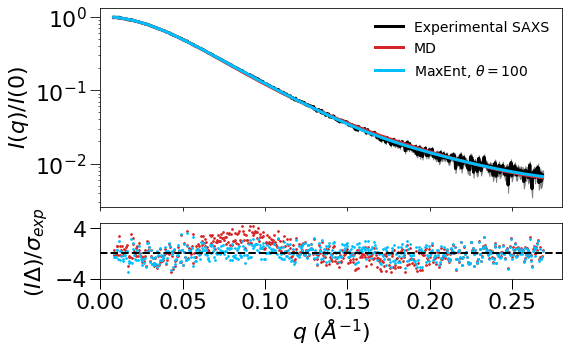

In [27]:
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = 100$"]
colors=["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

plt.tight_layout()

#### Figure 5C

In [6]:
rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")
weights = np.loadtxt("./MaxEnt_ensemble/output.files/bioen_wopt_theta_100_HOIP_extended.txt")
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

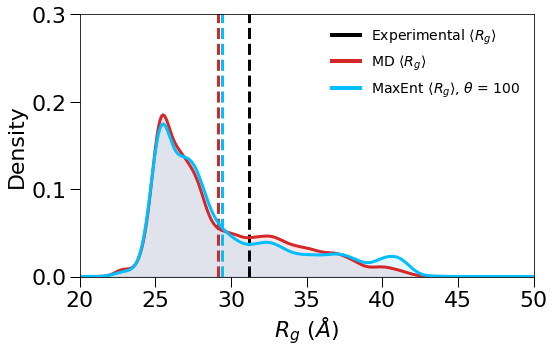

In [9]:
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")
ax.vlines(avg_maxent, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = 100")

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = 100"], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

plt.tight_layout()

plt.savefig("figure_5_subpanel_C.png", dpi=600)

#### Figure 5E

In [30]:
def get_histogram(xval, yval, nbins=100, weights=None):
    """ Compute a 2D histogram."""
    z, xedge, yedge = np.histogram2d(xval, yval, bins=nbins, weights=weights)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    
    return z.T, x, y 

def density(z):
    """ Normalize density."""
    return z / float(z.sum())

def free_energy(z):
    """ Compute a negative log of the density values."""
    prob = density(z)
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = prob.nonzero()
    free_energy[nonzero] = -np.log(prob[nonzero])
    
    return free_energy

def convert_fes(cv1, cv2, bins, weights=None):
    """ 2D histogram two collective variables and prepare input for FES plot."""
    ## Generate a 2D histogram of first two collective variables
    # Define range of collective variables
    xmin = np.floor(cv1.min())
    xmax = np.ceil(cv1.max())
    ymin = np.floor(cv2.min())
    ymax = np.ceil(cv2.max())

    # Calculate bin size for each collective variable
    xbin_size = np.abs(xmax - xmin) / float(bins)
    ybin_size = np.abs(ymax - ymin) / float(bins)
    
    xedges = np.arange(xmin, xmax, xbin_size)
    yedges = np.arange(ymin, ymax, ybin_size)

    # Histogram values into 2D array
    H, xedges, yedges = get_histogram(cv1, cv2, bins, weights=weights)
    f = free_energy(H)

    return f, xedges, yedges

def difference_fes(cv1, cv2, bins, weights, labels_dict):
    
    # Covnert CVs to a matrix
    H, xedges, yedges = convert_fes(cv1, cv2, bins)
    Hw, xedgesw, yedgesw = convert_fes(cv1, cv2, bins, weights)
    
    # Normalize to zero
    H -= H.min()
    Hw -= Hw.min()
    
    # Remove infs
    Hinf = H[~np.isinf(H)]
    Hwinf = Hw[~np.isinf(Hw)]
    
    # Set contour level base
    levels_base = np.round(Hinf.max())
    
    # Set range for non-weighted and weighted matrices
    if Hinf.min() < Hwinf.min():
        vmin = np.floor(Hinf.min())
    else:
        vmin = np.floor(Hwinf.min())
        
    if Hinf.max() > Hwinf.max():
        vmax = np.ceil(Hinf.max())
    else:
        vmax = np.ceil(Hwinf.max())
        
    # Set your own vmax
    vmax = 5
    
    # Set font and figure dimensions
    fs = 20
    fig = plt.figure()
    fig, (ax0, ax1, ax2) = plt.subplots(figsize=[22, 6], ncols=3)
    
    # Non-weighted
    im0 = ax0.contourf(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="Spectral", # GnBu_r
                         levels=np.linspace(vmin, int(vmax), int(levels_base * 2 + 1)),
                         corner_mask=True,
                         alpha=0.75)
    im0c = ax0.contour(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="gist_gray",
                         levels=np.linspace(vmin, int(vmax), int(levels_base * 2 + 1)),
                         linewidths=0.5,
                         corner_mask=True,
                         alpha=1)

    ax0.set_title("$-\ln p_{MD}$", fontsize=fs+4)

    cbar0 = fig.colorbar(im0, ax=ax0)
    cbar0.ax.tick_params(labelsize=20)
    cbar0.set_ticks(np.arange(vmin, vmax + 1, 1))
    # cbar0.ax.set_ylabel('$-\ln p$ MD', fontsize=fs)
    ax0.tick_params(labelsize=20)
    
    ax0.set_ylabel("$D_{IBR-RING2}$ $(\AA)$", fontsize=fs)
    ax0.set_xlabel("$D_{RING1-IBR}$ $(\AA)$", fontsize=fs)

    # Weighted
    im1 = ax1.contourf(Hw, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="Spectral", # GnBu_r
                         levels=np.linspace(vmin, int(vmax), int(levels_base * 2 + 1)),
                         corner_mask=True,
                         alpha=0.75)
    im1c = ax1.contour(Hw, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="gist_gray",
                         levels=np.linspace(vmin, int(vmax), int(levels_base * 2 + 1)),
                         linewidths=0.5,
                         corner_mask=True,
                         alpha=1)
    
    ax1.set_title("$-\ln p_{MaxEnt}$", fontsize=fs+4)
 
    for key in labels_dict.keys():
        
        x = labels_dict[key][0]
        y = labels_dict[key][1]
        
        ax1.plot(x, y, 'o', markersize=15, color="deepskyblue", markeredgewidth=2, markeredgecolor='k')
        ax1.annotate(key,
                     (x, y),
                     xytext=(4, 6),
                     textcoords='offset points',
                     fontsize=20,
                     weight="bold")
        
    custom_lines = [Line2D([0], [0], color="deepskyblue", lw=4)]

    cbar1 = fig.colorbar(im1, ax=ax1)
    cbar1.ax.tick_params(labelsize=20)
    cbar1.set_ticks(np.arange(vmin, vmax + 1, 1))

    ax1.tick_params(labelsize=20)
    
    ax1.set_ylabel("$D_{IBR-RING2}$ $(\AA)$", fontsize=fs)
    ax1.set_xlabel("$D_{RING1-IBR}$ $(\AA)$", fontsize=fs)
    
    # Difference matrix
    diff = Hw - H
    
    # Remove nans
    diffnan = diff[~np.isnan(diff)]
    
    # Set range for difference matrix
    if np.abs(diffnan.min()) > np.abs(diffnan.max()):
        vmin_max_diff = np.ceil(np.abs(diffnan.min()))
    else:
        vmin_max_diff = np.ceil(np.abs(diffnan.max()))
  
    im2 = ax2.contourf(diff, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="seismic_r", # GnBu_r
                         levels=np.linspace(-vmin_max_diff, int(vmin_max_diff), int(levels_base * 4 + 1)),
                         corner_mask=True,
                         alpha=0.75)
    im2c = ax2.contour(diff, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="gist_gray",
                         levels=np.linspace(-vmin_max_diff, int(vmin_max_diff), int(levels_base * 4 + 1)),
                         linewidths=0.75,
                         corner_mask=True,
                         alpha=1)
    
    for key in labels_dict.keys():
        
        x = labels_dict[key][0]
        y = labels_dict[key][1]
        
        ax2.plot(x, y, 'o', markersize=15, color="deepskyblue", markeredgewidth=2, markeredgecolor='k')
        ax2.annotate(key,
                     (x, y),
                     xytext=(4, 6),
                     textcoords='offset points',
                     fontsize=20,
                     weight="bold")
    
    ax2.set_title("$\Delta G$ MaxEnt - MD", fontsize=fs+4)
    ax2.set_ylabel("$D_{IBR-RING2}$ $(\AA)$", fontsize=fs)
    ax2.set_xlabel("$D_{RING1-IBR}$ $(\AA)$", fontsize=fs)


    cbar2 = fig.colorbar(im2, ax=ax2)
    cbar2.ax.tick_params(labelsize=20)
    cbar2.set_ticks(np.arange(-vmin_max_diff, vmin_max_diff + 1, vmin_max_diff / 2))
    ax2.tick_params(labelsize=20)
    
    plt.tight_layout()

In [31]:
def compute_distances_for_MaxEnt_cluster_labels(labels):
    """ Compute interdomain distances for selected cluster labels."""
    parameters = {}
    for i, label in enumerate(labels):
        parameters[i + 1] = calculate_RBR_dist("MaxEnt_ensemble/output.files/significant_states/HOIP_cluster_leaders/cluster_leader_{}.pdb".format(label))
    return parameters

In [32]:
# Compute distances for MaxEnt cluster labels
maxent_cluster_labels = [0, 15, 12, 17]
maxent_distances = compute_distances_for_MaxEnt_cluster_labels(labels=maxent_cluster_labels)

<ipython-input-30-70410117af8c>:144: RuntimeWarning: invalid value encountered in subtract
  diff = Hw - H


<Figure size 432x288 with 0 Axes>

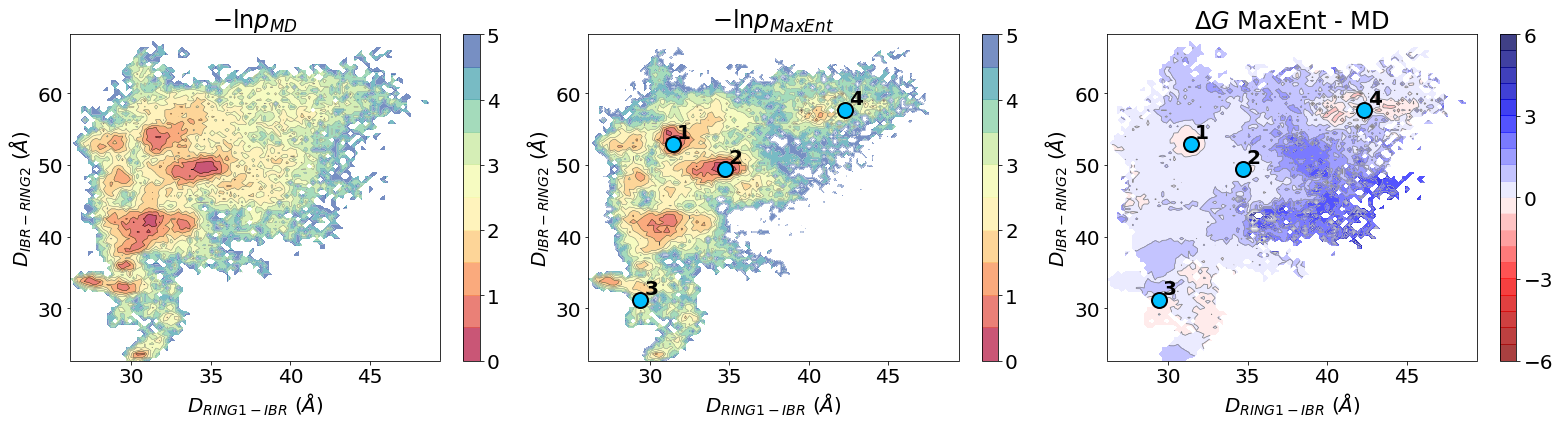

In [33]:
cv1 = np.loadtxt("MD_ensemble/MD_collective_variables/d1.txt")
cv2 = np.loadtxt("MD_ensemble/MD_collective_variables/d2.txt")
weights = np.loadtxt("./MaxEnt_ensemble/output.files/bioen_wopt_theta_100_HOIP_extended.txt")
difference_fes(cv1=cv1, cv2=cv2, bins=100, weights=weights, labels_dict=maxent_distances)

#### Figure 6A

In [10]:
# Define a set of values
maxpars_rg = [25.24, 29.43, 39.98, 33.76]
maxpars_p = [0.43872833, 0.18072769, 0.10880706, 0.25528143]
maxpars_avg = sum(np.array(maxpars_p) * np.array(maxpars_rg))

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")
weights = np.loadtxt("./MaxEnt_ensemble/output.files/bioen_wopt_theta_100_HOIP_extended.txt")
avg_maxent = sum(rgyr * weights)

In [11]:
density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.linspace(20, 45, 100)

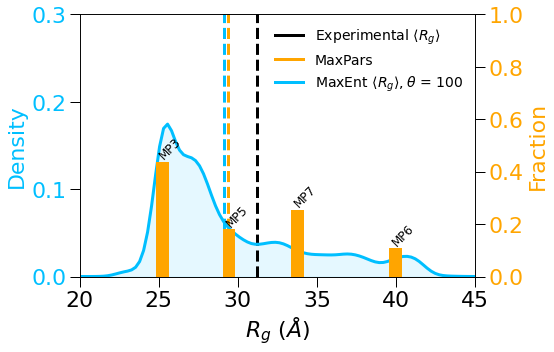

In [15]:
# Plot rgyr distribution
tick_params = dict(labelsize=22, length=10, width=1)

fs = 22
fig, ax1 = plt.subplots(figsize=[8, 5])

theta = 100

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.linspace(20, 45, 100)

ax1.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax1.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)
ax1.vlines(np.mean(rgyr), 0, 1,
          linestyle="--",
          color="deepskyblue",
          linewidth=3) 
ax1.vlines(31.2, 0, 1,
          linestyle="--",
          linewidth=3,
          color="k",
          label=r"Experimental $\langle R_g \rangle$")

ax1.set_xlim(20, 45)
ax1.set_ylim(0, 0.3)
ax1.tick_params(**tick_params, axis="y", labelcolor="deepskyblue")

ax1.set_xlabel(r'$R_g$ ($\AA$)', fontsize=fs)
ax1.set_ylabel(r'Density', fontsize=fs, color="deepskyblue")

ax2 = ax1.twinx()
ax2.bar(maxpars_rg, maxpars_p, color="orange", zorder=1)

ax2.text(maxpars_rg[0] + 0.5, maxpars_p[0], "MP3", ha='center', va='bottom', fontsize=12, rotation=45)
ax2.text(maxpars_rg[1]+ 0.5, maxpars_p[1], "MP5", ha='center', va='bottom', fontsize=12, rotation=45)
ax2.text(maxpars_rg[2]+ 0.5, maxpars_p[2], "MP6", ha='center', va='bottom', fontsize=12, rotation=45)
ax2.text(maxpars_rg[3]+ 0.5, maxpars_p[3], "MP7", ha='center', va='bottom', fontsize=12, rotation=45)

ax1.vlines(maxpars_avg, 0, 1,
          linestyle="--",
          color="orange",
          linewidth=3) 

ax2.set_ylim(0, 1)
ax2.tick_params(**tick_params, axis="y", labelcolor="orange")
ax2.set_ylabel(r'Fraction', fontsize=fs, color="orange")

custom_lines = [Line2D([0], [0], color="k", lw=3),
                Line2D([0], [0], color="orange", lw=3),
                Line2D([0], [0], color="deepskyblue", lw=3)]
labels = [r"Experimental $\langle R_g \rangle$", 
          "MaxPars",
          r"MaxEnt $\langle R_g \rangle, \theta$ = {}".format(theta)]
ax1.legend(custom_lines, labels, fontsize=14, frameon=False, loc="upper right")

ax1.tick_params(**tick_params, axis="x")

plt.tight_layout()

plt.savefig("figure_6_subpanel_A.png", dpi=600)

#### Figure 6B

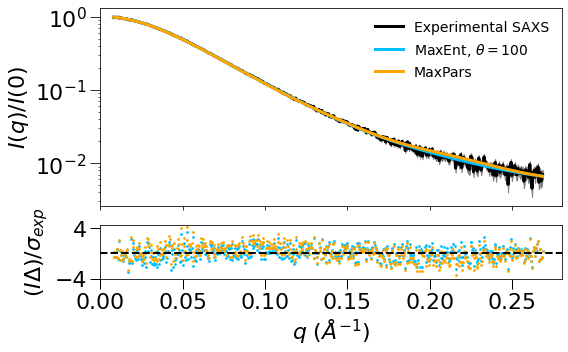

In [14]:
# Prepare data
i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MD_ensemble/scattering_profiles/HOIP_extended_combined_MD_simulations_1us.fit", skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/output.files/bioen_scattering_wopt_theta_100.dat", skiprows=0)
fit_maxent = fit_maxent / i0

states = bs.load_pickle("MaxPars_ensemble/HOIP_extended_basis_set.pkl")
opt_curve = states['182:184:86:149:227:281:44:143']["opt_curve"]
fit_maxpars = opt_curve.get_fit() / i0

fits = [fit_maxent, fit_maxpars.T.squeeze()]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma
residuals_maxpars = (iq - fit_maxpars.T).squeeze() / sigma

residuals = [residuals_maxent, residuals_maxpars]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MaxEnt, $\\theta = 100$", "MaxPars"]
colors=["deepskyblue", "orange"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

plt.tight_layout()

plt.savefig("figure_6_subpanel_B.png", dpi=600)

#### Supplementary Figure 4

In [36]:
def get_histogram(xval, yval, nbins=100):
    """ Compute a 2D histogram."""
    z, xedge, yedge = np.histogram2d(xval, yval, bins=nbins)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    
    return z.T, x, y 

def density(z):
    """ Normalize density."""
    return z / float(z.sum())

def free_energy(z):
    """ Compute a negative log of the density values."""
    prob = density(z)
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = prob.nonzero()
    free_energy[nonzero] = -np.log(prob[nonzero])
    
    return free_energy

def prepare_two_cvs(cv1, cv2, bins, weights=None):
    """ Prepare CVs for plotting."""
    
    # Define range of collective variables
    xmin = np.floor(cv1.min())
    xmax = np.ceil(cv1.max())
    ymin = np.floor(cv2.min())
    ymax = np.ceil(cv2.max())

    # Calculate bin size for each collective variable
    xbin_size = (xmax - xmin) / bins
    ybin_size = (ymax - ymin) / bins
    xedges = np.arange(xmin, xmax, xbin_size)
    yedges = np.arange(ymin, ymax, ybin_size)

    # Histogram values into 2D array
    H, xedges, yedges = get_histogram(cv1, cv2, bins)
    f = free_energy(H)

    return f, xedges, yedges


def plot_2D_contour_mod(H, xedges, yedges, cv1, cv2, labels_dict):
    """ Plot 2D FES contour plot."""
    
    fs = 22
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(111)
    
    H -= H.min()
    m = H[np.isfinite(H)].max()
    
    contour = ax.contourf(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="Spectral", # GnBu_r
                         levels=np.linspace(0, int(np.round(m)), int(np.round(m) * 2 + 1)),
                         corner_mask=True,
                         alpha=0.75)
    cbar = fig.colorbar(contour, ax = ax)
    cbar.ax.tick_params(labelsize=fs)
    cbar.ax.set_ylabel("$-\ln P$ MD", fontsize=fs)
    
    contour = ax.contour(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="gist_gray",
                         levels=np.linspace(0, int(np.round(m)), int(np.round(m) * 2 + 1)),
                         linewidths=1,
                         corner_mask=True,
                         alpha=1)
    
    ax.plot(cv1[0], cv2[0], 'o', markersize=25, color="tab:orange", markeredgewidth=1, markeredgecolor='k')
    ax.plot(cv1[0], cv2[0], 'x', markersize=18, color="tab:orange", fillstyle="none", markeredgewidth=1, markeredgecolor='k')
    
    for key in labels_dict.keys():
    
        xytext = (4, 6)
        if key == "ME4" or key == "MP6":
            xytext = (4, -20)
        
        x = labels_dict[key][0]
        y = labels_dict[key][1]

        ax.plot(x, y, 'o', markersize=15, color="w", markeredgewidth=3, markeredgecolor='k')
        ax.annotate(key,
                 (x, y),
                 xytext=xytext,
                 textcoords='offset points',
                 fontsize=20,
                 weight="bold")
        
    ax.tick_params(labelsize=fs)
    
    ax.set_xlabel("$D_{R1-IBR}$ $(\AA)$", fontsize=fs)
    ax.set_ylabel("$D_{IBR-R2}$ $(\AA)$", fontsize=fs)
    
    fig.tight_layout()


def two_variable_contour(cv1, cv2, bins, labels_dict, weights=None):
    """ Plot a 2D FES contour for two CVs."""
    
    # Check if the weights are provided
    if weights is not None:
        weights = load_weights(weights)

    H, xedges, yedges = prepare_two_cvs(cv1, cv2, bins, weights=weights)
    plot_2D_contour_mod(H, xedges, yedges, cv1, cv2, labels_dict)

    return

In [37]:
# Compute distances for MaxEnt cluster labels
maxent_cluster_labels = [0, 15, 12, 17]
maxent_distances = compute_distances_for_MaxEnt_cluster_labels(labels=maxent_cluster_labels)
maxent_distances["ME1"] = maxent_distances.pop(1)
maxent_distances["ME2"] = maxent_distances.pop(2)
maxent_distances["ME3"] = maxent_distances.pop(3)
maxent_distances["ME4"] = maxent_distances.pop(4)

In [38]:
def compute_distances_for_MaxPars_cluster_labels(labels):
    """ Compute interdomain distances for selected cluster labels."""
    parameters = {}
    for i, label in enumerate(labels):
        parameters["MP{}".format(label)] = calculate_RBR_dist("MaxPars_ensemble/HOIP_extended_basis_set/MP{}.pdb".format(label))
    return parameters

In [39]:
# Compute distances for MaxPars cluster labels
maxpars_labels = [3, 5, 6, 7]
maxpars_distances = compute_distances_for_MaxPars_cluster_labels(labels=maxpars_labels)

In [40]:
cv1 = np.loadtxt("MD_ensemble/MD_collective_variables/d1.txt")
cv2 = np.loadtxt("MD_ensemble/MD_collective_variables/d2.txt")

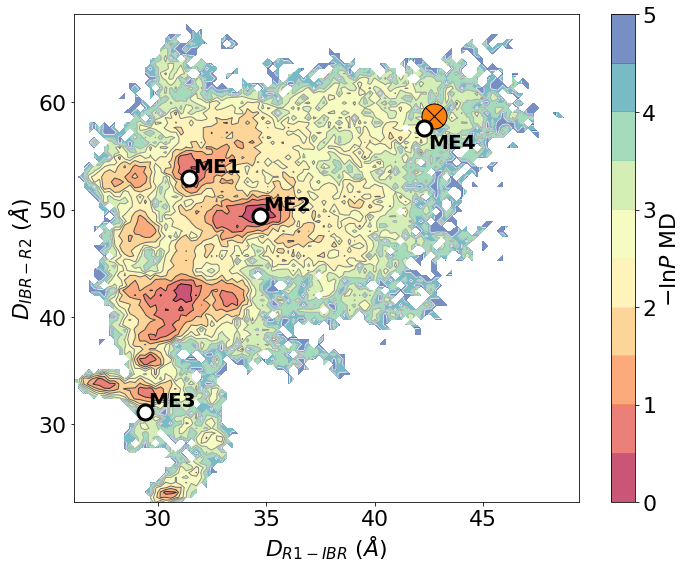

In [41]:
two_variable_contour(cv1=cv1, cv2=cv2, bins=100, labels_dict=maxent_distances)

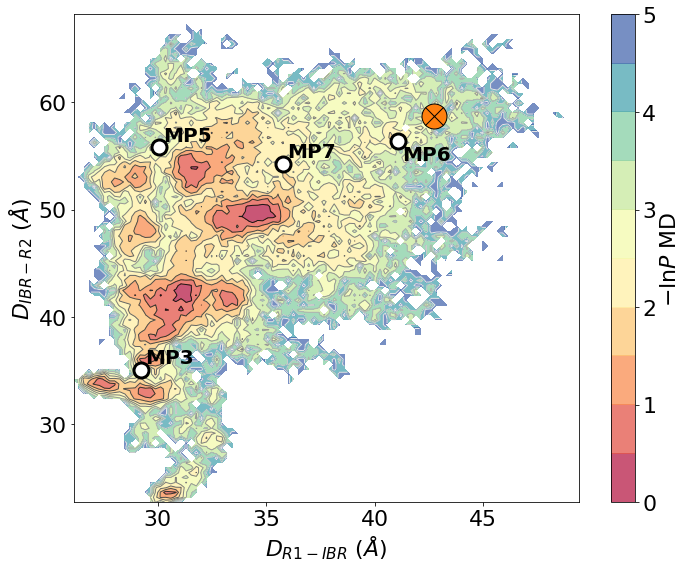

In [42]:
two_variable_contour(cv1=cv1, cv2=cv2, bins=100, labels_dict=maxpars_distances)

#### Supplementary Figure 2

In [16]:
# Load rgyr values
rgyr = np.loadtxt("./MD_ensemble/MD_collective_variables/rgyr.txt")

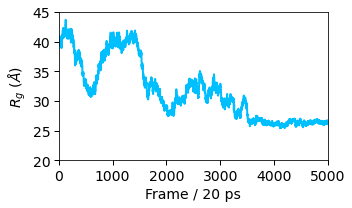

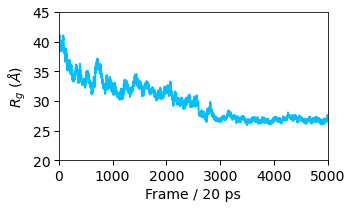

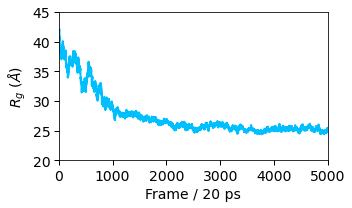

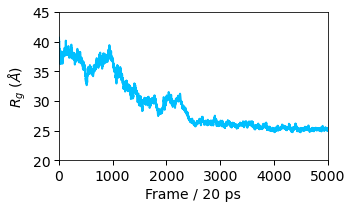

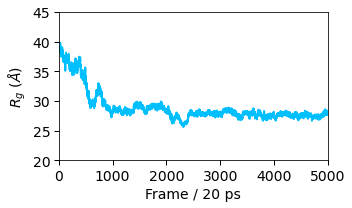

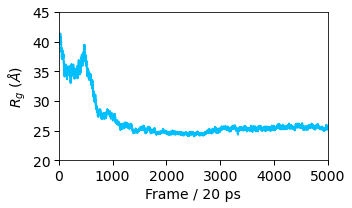

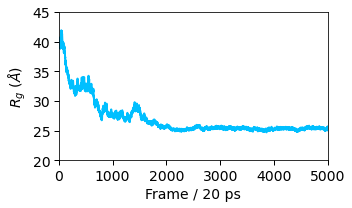

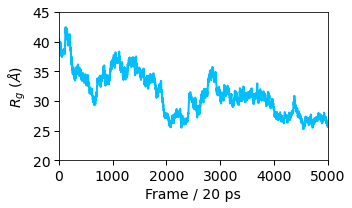

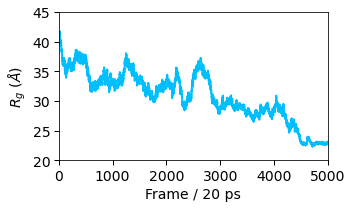

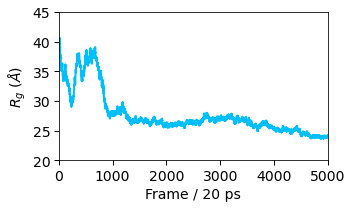

In [17]:
tick_params = dict(labelsize=14, length=5, width=1)
fs = tick_params["labelsize"]
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

for i in range(10):

    fig = plt.figure(figsize=[5, 3])
    ax = fig.add_subplot(111)
    ax.plot(rgyr[0 + 5000 * i : 5000 +  5000 * i], linewidth=2, color="deepskyblue")
    
    ax.set_xlim(0, 5000)
    ax.set_ylim(20, 45)
    
    ax.tick_params(**tick_params)

    ax.set_xlabel("Frame / 20 ps", fontsize=fs)
    ax.set_ylabel('$R_g$ ($\AA$)', fontsize=fs)

#### Supplementary Figure 2

In [18]:
# Load trajectory
traj = mdt.load(filename_or_filenames="./MD_ensemble/MD_traj/HOIP_extended_combined_MD_simulations_1us.xtc", top="./MD_ensemble/MD_traj/HOIP_extended.pdb")

In [19]:
def compute_rmsd(traj, query_selection, frame):
    """ Compute RMSD for a given trajectory."""
    atom_selection = traj.topology.select(query_selection)
    rmsds = mdt.rmsd(target=traj, reference=traj, frame=frame, atom_indices=atom_selection, parallel=True, precentered=False)
    return rmsds

In [20]:
# Compute RMSDs
rmsds = compute_rmsd(traj=traj, query_selection="backbone", frame=0)

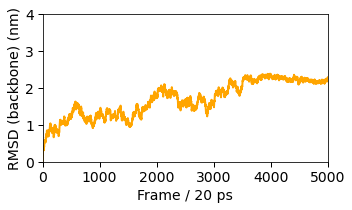

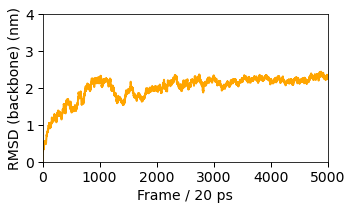

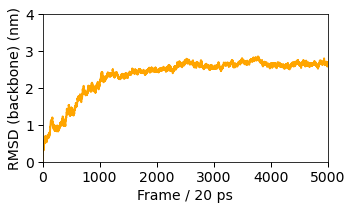

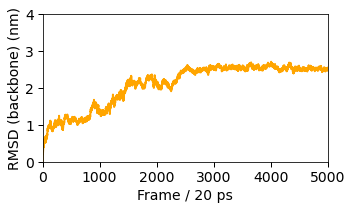

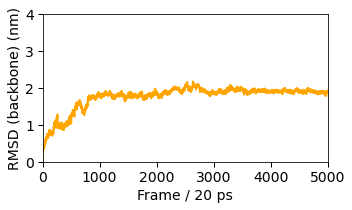

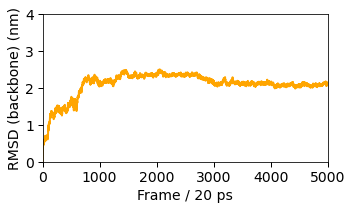

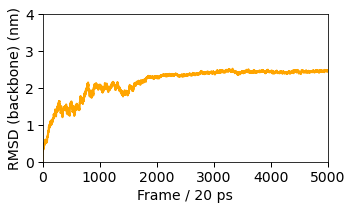

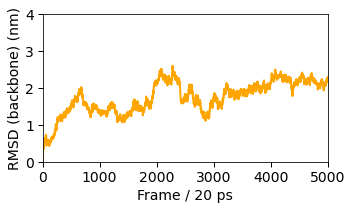

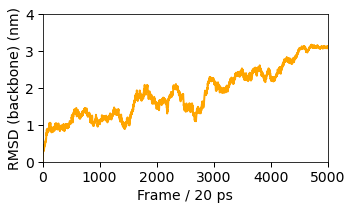

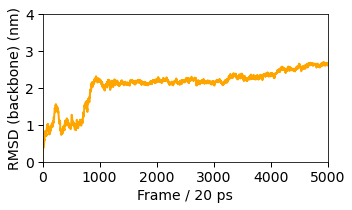

In [21]:
tick_params = dict(labelsize=14, length=5, width=1)
fs = tick_params["labelsize"]
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

for i in range(10):

    fig = plt.figure(figsize=[5, 3])
    ax = fig.add_subplot(111)
    ax.plot(rmsds[0 + 5000 * i : 5000 +  5000 * i], linewidth=2, color="orange")
    
    ax.set_xlim(0, 5000)
    ax.set_ylim(0, 4)
    
    ax.tick_params(**tick_params)

    ax.set_xlabel("Frame / 20 ps", fontsize=fs)
    ax.set_ylabel('RMSD (backbone) (nm)', fontsize=fs)

#### Supplementary Figure 2

In [22]:
# Load d1 and d2
d1s = np.loadtxt("./MD_ensemble/MD_collective_variables/d1.txt")
d2s = np.loadtxt("./MD_ensemble/MD_collective_variables/d2.txt")

In [24]:
def get_histogram(xval, yval, range_, nbins=100):
    """ Compute a 2D histogram."""
    z, xedge, yedge = np.histogram2d(xval, yval, nbins, range_)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    
    return z.T, x, y 

def density(z):
    """ Normalize density."""
    return z / float(z.sum())

def free_energy(z):
    """ Compute a negative log of the density values."""
    prob = density(z)
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = prob.nonzero()
    free_energy[nonzero] = -np.log(prob[nonzero])
    
    return free_energy

def prepare_two_cvs(cv1, cv2, bins, weights=None):
    """ Prepare CVs for plotting."""
    
    # Define range of collective variables
    xmin = 25
    xmax = 50
    ymin = 20
    ymax = 70
    range_ = [[xmin, xmax], [ymin, ymax]]
    
    # Histogram values into 2D array
    H, xedges, yedges = get_histogram(cv1, cv2, range_, bins)
    f = free_energy(H)

    return f, xedges, yedges


def plot_2D_contour(H, xedges, yedges, cv1, cv2):
    """ Plot 2D FES contour plot."""
    
    fs = 30
    fig = plt.figure(figsize=[9, 8])
    ax = fig.add_subplot(111)
    
    H -= H.min()
    # m = H[np.isfinite(H)].max()
    m = 6
    
    contour = ax.contourf(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="Spectral", # GnBu_r
                         levels=np.linspace(0, int(np.round(m)), int(np.round(m) * 2 + 1)),
                         corner_mask=True,
                         alpha=0.75)
    cbar = fig.colorbar(contour, ax = ax)
    cbar.ax.tick_params(labelsize=fs)
    cbar.ax.set_ylabel("$-\ln P$ MD", fontsize=fs)
    
    contour = ax.contour(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         cmap="gist_gray",
                         levels=np.linspace(0, int(np.round(m)), int(np.round(m) * 2 + 1)),
                         linewidths=1,
                         corner_mask=True,
                         alpha=1)
    
    ax.plot(cv1[0], cv2[0], 'o', markersize=25, color="tab:orange", markeredgewidth=1, markeredgecolor='k')
    ax.plot(cv1[0], cv2[0], 'x', markersize=18, color="tab:orange", fillstyle="none", markeredgewidth=1, markeredgecolor='k')
        
    ax.set_xticks([25, 30, 35, 40, 45, 50])
    ax.set_yticks([20, 30, 40, 50, 60, 70]) 
        
    ax.tick_params(labelsize=fs)
    
    ax.set_xlabel("$D_{R1-IBR}$ $(\AA)$", fontsize=fs)
    ax.set_ylabel("$D_{IBR-R2}$ $(\AA)$", fontsize=fs)
    
    # fig.tight_layout()


def two_variable_contour(cv1, cv2, bins, weights=None):
    """ Plot a 2D FES contour for two CVs."""
    
    # Check if the weights are provided
    if weights is not None:
        weights = load_weights(weights)

    H, xedges, yedges = prepare_two_cvs(cv1, cv2, bins, weights=weights)
    plot_2D_contour(H, xedges, yedges, cv1, cv2)

    return

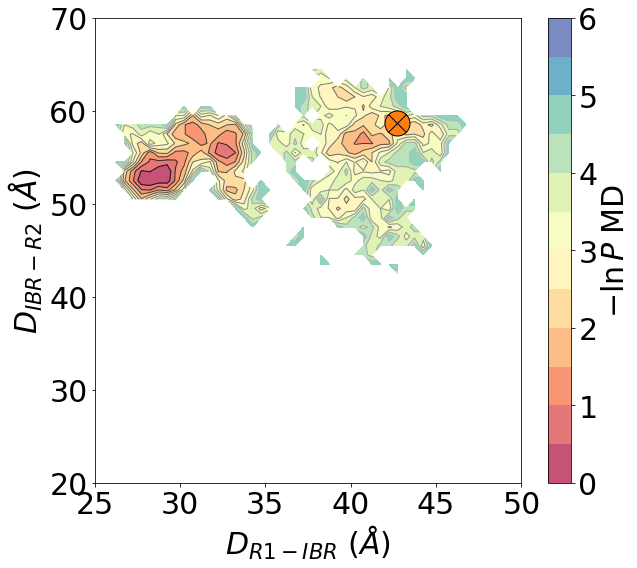

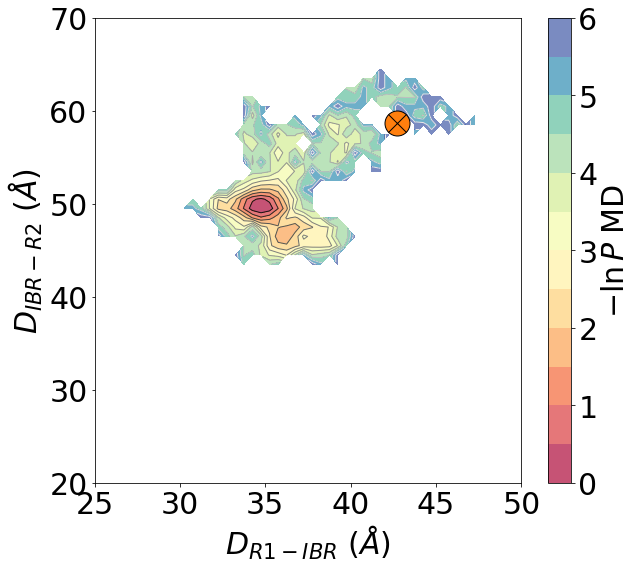

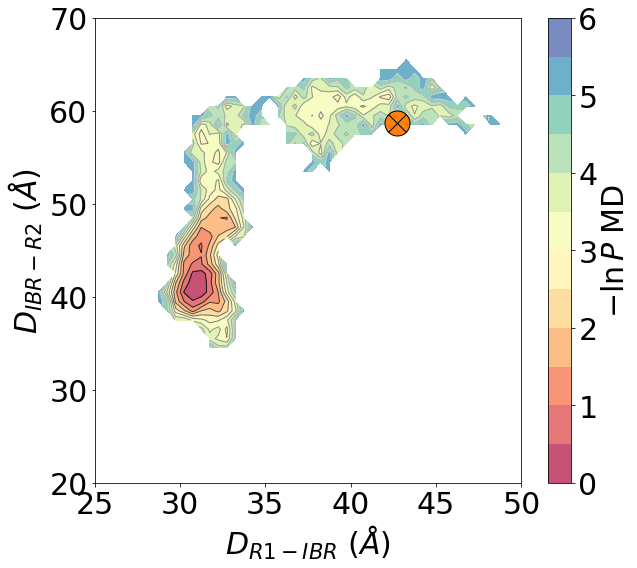

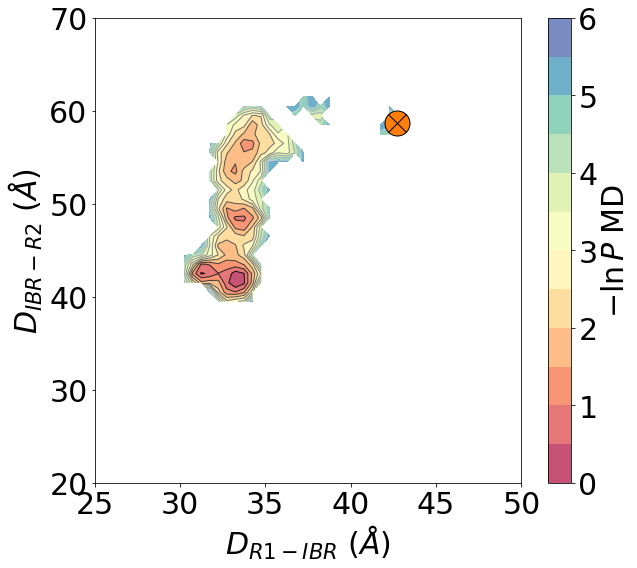

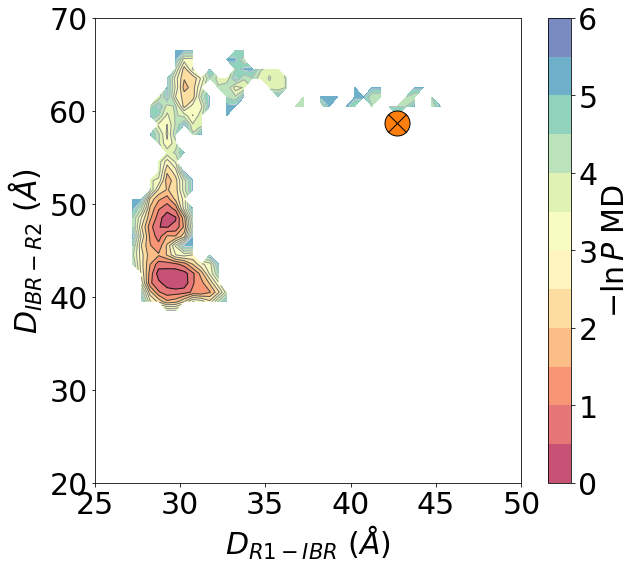

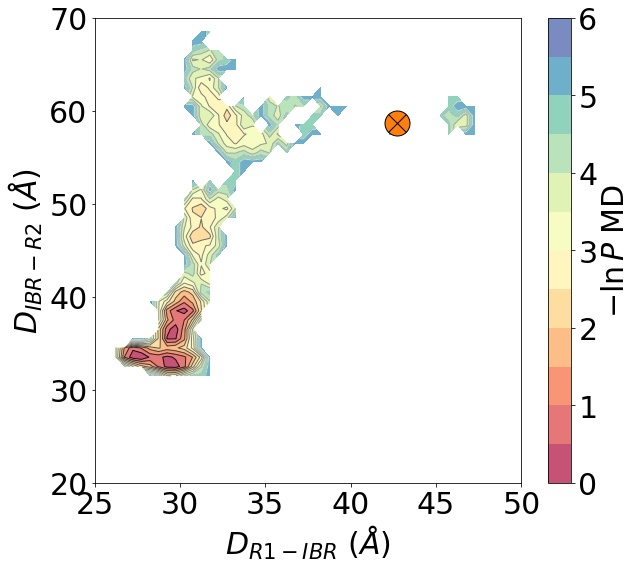

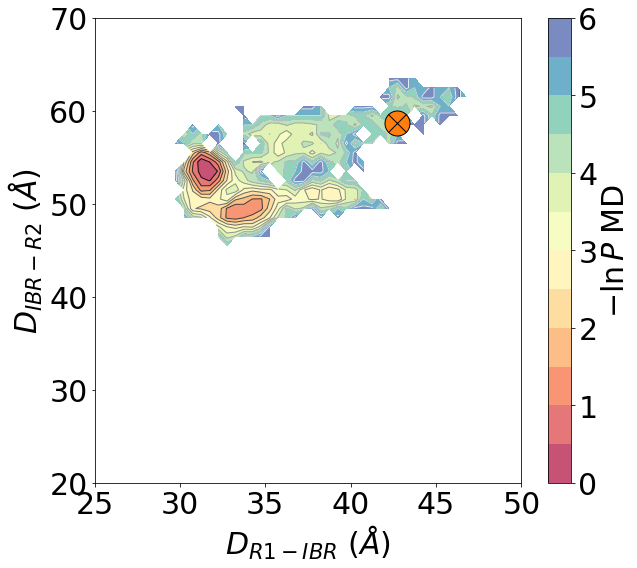

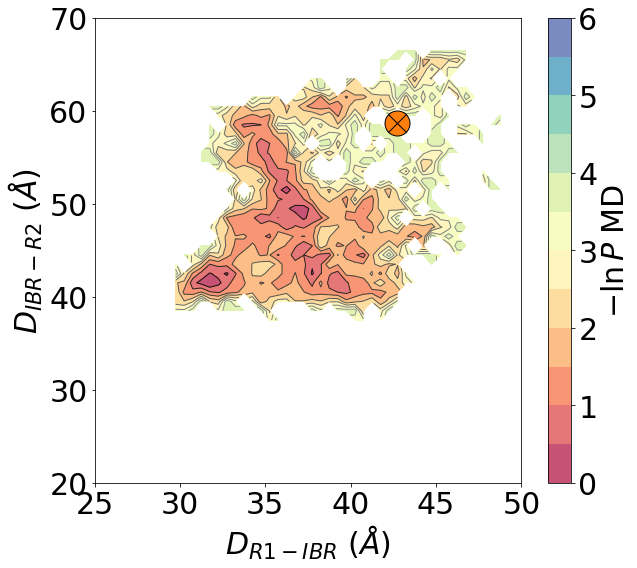

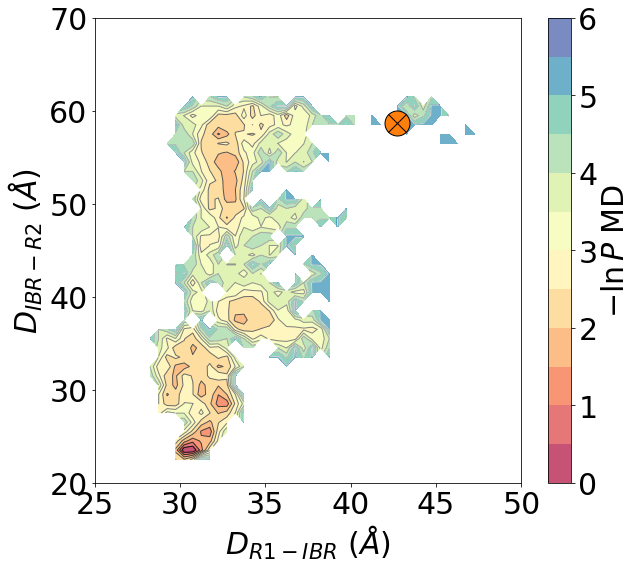

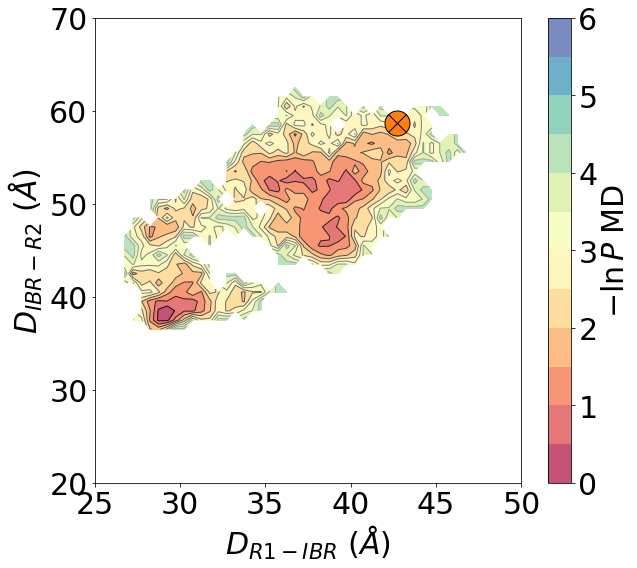

In [25]:
for i in range(10):
    cv1 = d1s[0 + 5000 * i : 5000 +  5000 * i]
    cv2 = d2s[0 + 5000 * i : 5000 +  5000 * i]
    two_variable_contour(cv1=cv1, cv2=cv2, bins=50)
    # plt.title("Simulations: {}".format(i + 1), fontsize=20)

##### Supplementary Figure 6

In [15]:
# Prepare data
combinations_1 = [1.87, 1.24, 1.85, 1.38, 1.25, 1.62, 1.41, 6.34, 1.31, 2.57]
combinations_2 = [1.59, 1.73, 1.12, 2.5, 1.16, 1.85]
combinations_3 = [1.13, 1.16, 1.33, 1.14, 1.12, 1.16]
combinations_5 = [1.12, 1.12, 1.12, 1.18, 1.19, 1.15]
combinations_10 = [1.12]
combinations_all = [np.mean(combinations_1), np.mean(combinations_2), np.mean(combinations_3), np.mean(combinations_5), np.mean(combinations_10)]
error_all = [np.std(combinations_1), np.std(combinations_2), np.std(combinations_3), np.std(combinations_5), np.std(combinations_10)]
num_of_sims = [1, 2, 3, 5, 10]

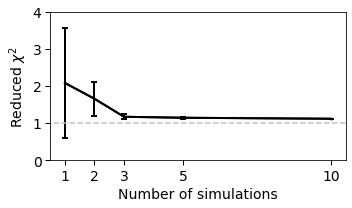

In [20]:
tick_params = dict(labelsize=14, length=5, width=1)
fs = tick_params["labelsize"]
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[5, 3])
ax = fig.add_subplot(111)

# ax.boxplot(combinations_all, positions=[1, 2, 3, 5, 10], zorder=2)
ax.plot(num_of_sims, combinations_all, linewidth=2, marker="o", markersize=1, markerfacecolor="white", color="k", zorder=2)
ax.errorbar(x=num_of_sims, y=combinations_all, yerr=error_all, color="k", zorder=1, capsize=3, capthick=2, linewidth=2)
ax.hlines(y=1, xmin=-1, xmax=11, color="silver", linestyles="--", zorder=1)

ax.set_xlim(0.5, 10.5)
ax.set_ylim(0, 4)

ax.set_xticks([1, 2, 3, 5, 10])
ax.set_yticks([0, 1, 2, 3, 4])

ax.tick_params(**tick_params)

ax.set_xlabel("Number of simulations", fontsize=fs)
ax.set_ylabel('Reduced $\chi^{2}$', fontsize=fs)

plt.tight_layout()

##### Supplementary Figure 5 and 7

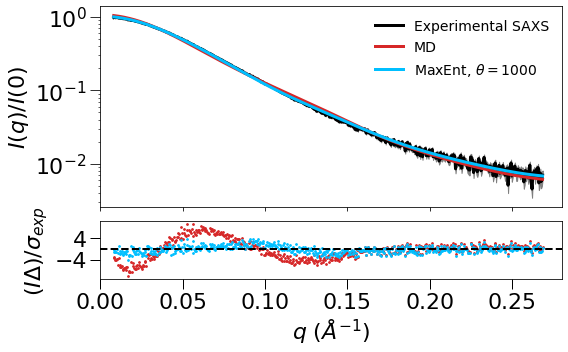

In [31]:
# Define data
i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_1/output.files/bioen_scattering_init.dat", skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_1/output.files/bioen_scattering_wopt_theta_1000.dat", skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = 1000$"]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

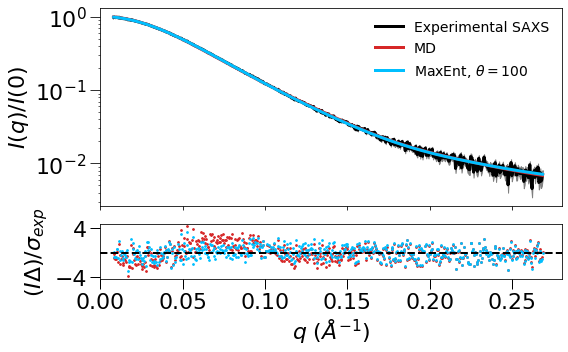

In [33]:
# Define data
i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_1_2_3/output.files/bioen_scattering_init.dat", skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_1_2_3/output.files/bioen_scattering_wopt_theta_100.dat", skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = 100$"]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

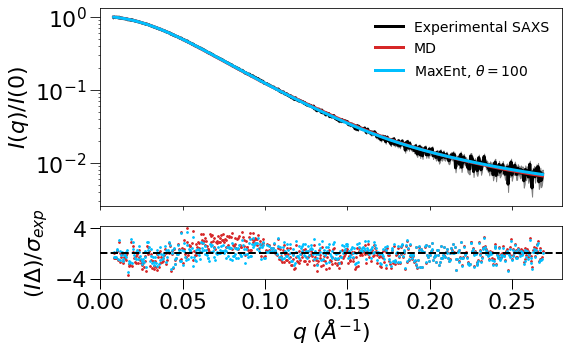

In [34]:
# Define data
i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_1_2_3_4_5/output.files/bioen_scattering_init.dat", skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_1_2_3_4_5/output.files/bioen_scattering_wopt_theta_100.dat", skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = 100$"]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

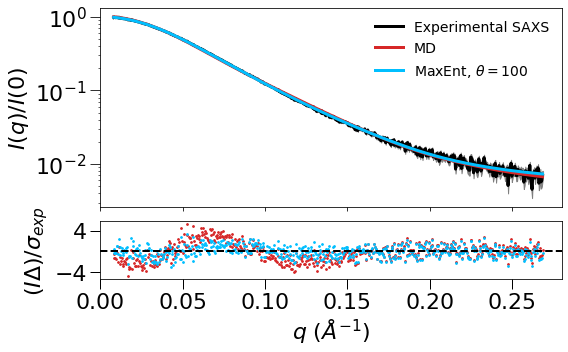

In [15]:
# Define data
simulations = "2"
theta = 100

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_init.dat".format(simulations), skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_wopt_theta_{}.dat".format(simulations, theta), skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = {}$".format(theta)]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

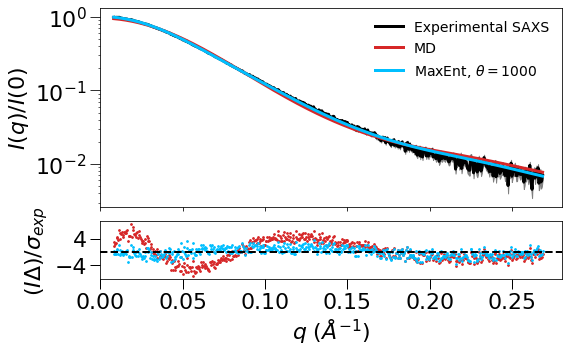

In [16]:
# Define data
simulations = "3"
theta = 1000

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_init.dat".format(simulations), skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_wopt_theta_{}.dat".format(simulations, theta), skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = {}$".format(theta)]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

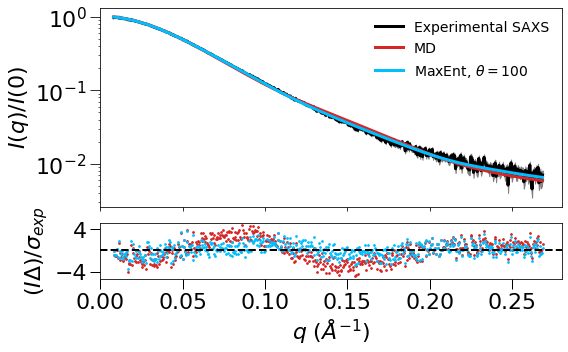

In [17]:
# Define data
simulations = "4"
theta = 100

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_init.dat".format(simulations), skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_wopt_theta_{}.dat".format(simulations, theta), skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = {}$".format(theta)]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

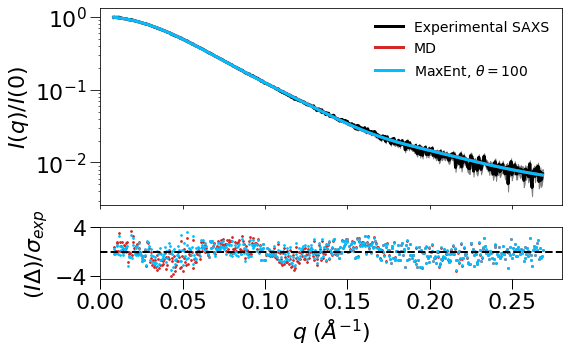

In [18]:
# Define data
simulations = "5"
theta = 100

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_init.dat".format(simulations), skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_wopt_theta_{}.dat".format(simulations, theta), skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = {}$".format(theta)]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

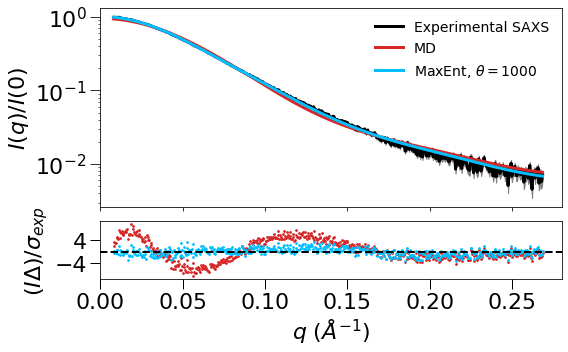

In [19]:
# Define data
simulations = "6"
theta = 1000

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_init.dat".format(simulations), skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_wopt_theta_{}.dat".format(simulations, theta), skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = {}$".format(theta)]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

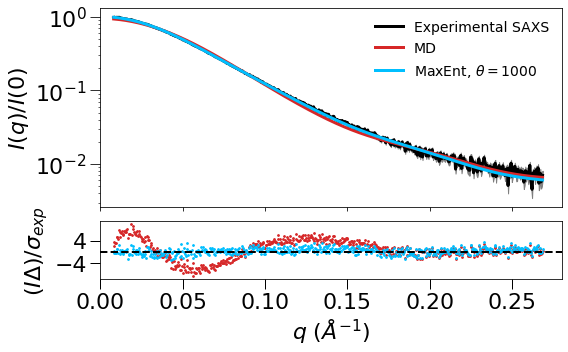

In [21]:
# Define data
simulations = "7"
theta = 1000

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_init.dat".format(simulations), skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_wopt_theta_{}.dat".format(simulations, theta), skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = {}$".format(theta)]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

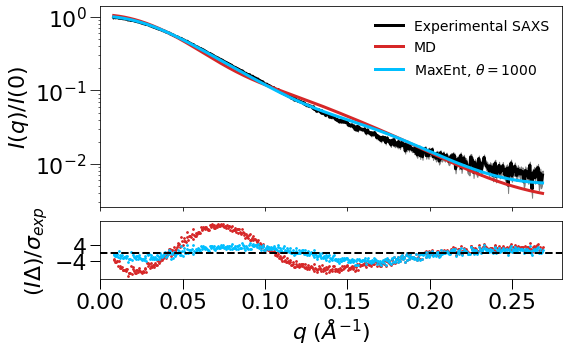

In [22]:
# Define data
simulations = "8"
theta = 1000

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_init.dat".format(simulations), skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_wopt_theta_{}.dat".format(simulations, theta), skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = {}$".format(theta)]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

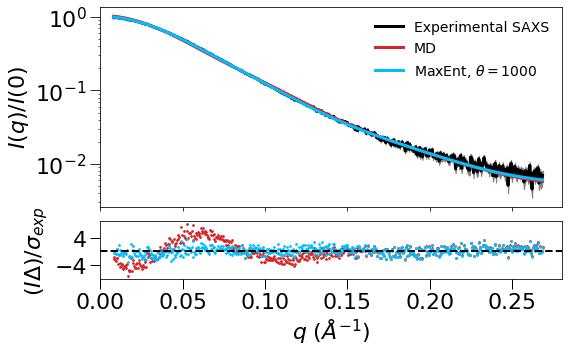

In [24]:
# Define data
simulations = "9"
theta = 1000

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_init.dat".format(simulations), skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_wopt_theta_{}.dat".format(simulations, theta), skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = {}$".format(theta)]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

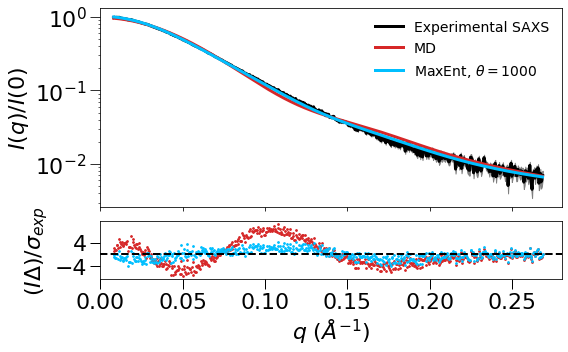

In [26]:
# Define data
simulations = "10"
theta = 1000

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_init.dat".format(simulations), skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_wopt_theta_{}.dat".format(simulations, theta), skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = {}$".format(theta)]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

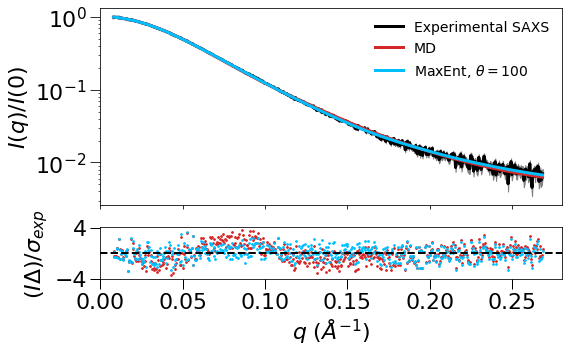

In [28]:
# Define data
simulations = "4_5"
theta = 100

i0 = 0.015
q, iq, sigma = load_dat(path_to_dat="experimental_data/HOIP_experimental_SAXS.dat", skiprows=0)
iq = iq / i0
sigma = sigma / i0

fit_md = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_init.dat".format(simulations), skiprows=0)
fit_md = fit_md / i0

fit_maxent = get_fit("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_scattering_wopt_theta_{}.dat".format(simulations, theta), skiprows=0)
fit_maxent = fit_maxent / i0
fits = [fit_md, fit_maxent]

residuals_md = (iq - fit_md) / sigma
residuals_maxent = (iq - fit_maxent) / sigma

residuals = [residuals_md, residuals_maxent]

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fig = plt.figure(figsize=[8, 5])

titles = ["MD", "MaxEnt, $\\theta = {}$".format(theta)]
colors = ["tab:red", "deepskyblue"]

ax1 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=3)

ax1.plot(q, iq, color="k", linewidth=3, zorder=2, label="Experimental SAXS")
ax1.fill_between(q, iq-sigma, iq+sigma, color='tab:grey', alpha=1, zorder=1)

for idx, fit in enumerate(fits):
    ax1.plot(q, fit, color=colors[idx], alpha=1, linewidth=3, label=titles[idx])

ax1.semilogy()
ax1.tick_params(labelsize=22, axis="y", length=10)
ax1.set_xticklabels([])
ax1.set_xlim(0, 0.28)
ax1.set_ylabel('$I(q)/I(0)$', fontsize=22)
ax1.legend(fontsize=14, frameon=False)


ax2 = plt.subplot2grid((4, 3), (3, 0), colspan=3)

for idx, residual in enumerate(residuals):
    ax2.scatter(q, residual, s=3, color=colors[idx], zorder=1, marker='o', alpha=1)
        
ax2.axhline(y=0, xmin=0, xmax=1, ls='--', color="k", zorder=2, linewidth=2)
ax2.tick_params(**tick_params)
ax2.set_xlim(0, 0.28)
ax2.set_xlabel('$q$ $(\AA^{-1})$', fontsize=22)
ax2.set_yticks([-4, 4])
ax2.set_ylabel('$(I\Delta)/\sigma_{exp}$', fontsize=22)

##### Supplementary Figure 5 and 7

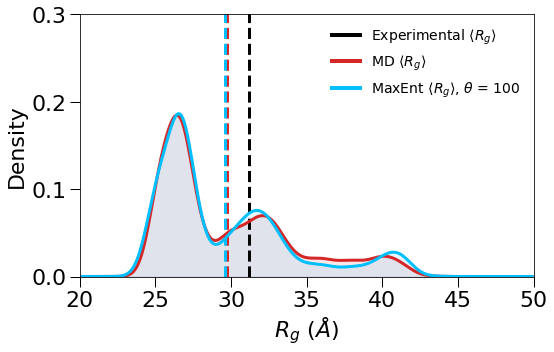

In [29]:
# Define data
rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[:15000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_1_2_3/output.files/bioen_wopt_theta_100_HOIP_extended.txt")
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")
ax.vlines(avg_maxent, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = 100")

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = 100"], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

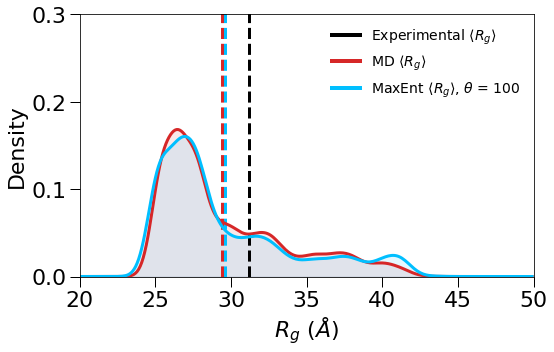

In [30]:
# Define data
rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[:25000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_1_2_3_4_5/output.files/bioen_wopt_theta_100_HOIP_extended.txt")
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = 100")

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = 100"], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

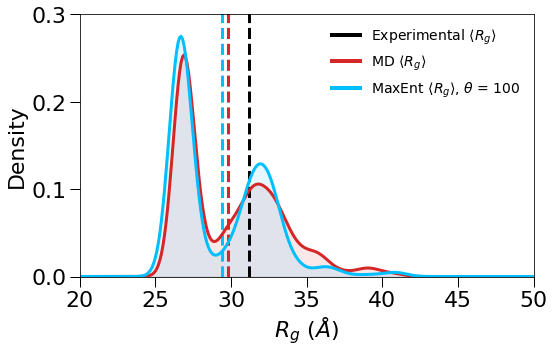

In [27]:
# Define data
simulations = "2"
theta = 100

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[5000:10000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_wopt_theta_{}_HOIP_extended.txt".format(simulations, theta))
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta))

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta)], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

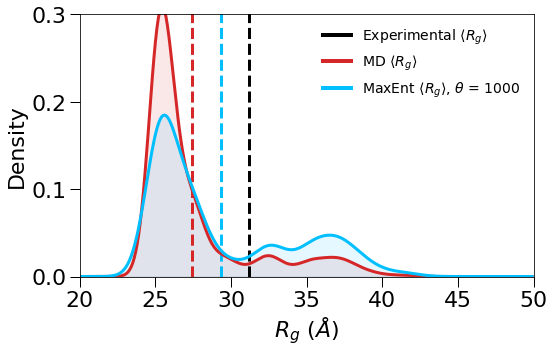

In [29]:
# Define data
simulations = "3"
theta = 1000

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[10000:15000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_wopt_theta_{}_HOIP_extended.txt".format(simulations, theta))
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta))

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta)], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

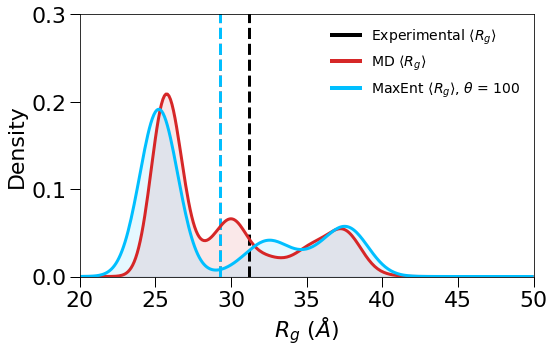

In [30]:
# Define data
simulations = "4"
theta = 100

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[15000:20000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_wopt_theta_{}_HOIP_extended.txt".format(simulations, theta))
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta))

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta)], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

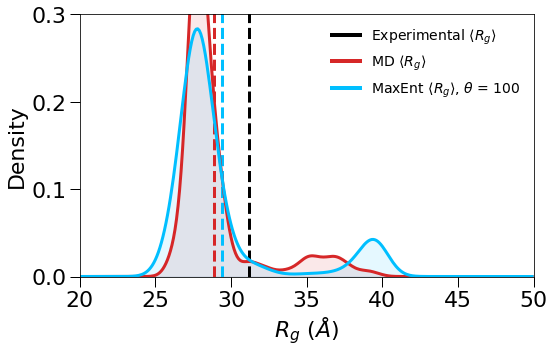

In [31]:
# Define data
simulations = "5"
theta = 100

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[20000:25000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_wopt_theta_{}_HOIP_extended.txt".format(simulations, theta))
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta))

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta)], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

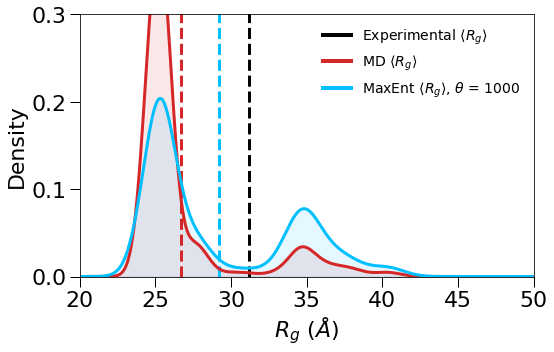

In [32]:
# Define data
simulations = "6"
theta = 1000

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[25000:30000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_wopt_theta_{}_HOIP_extended.txt".format(simulations, theta))
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta))

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta)], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

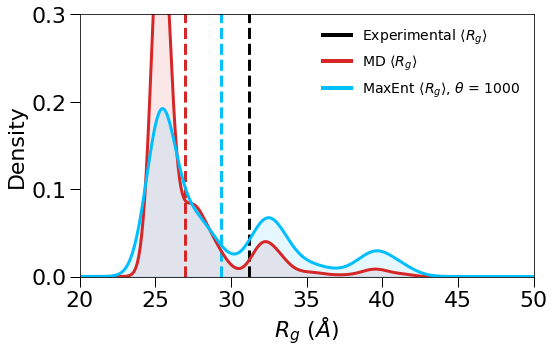

In [34]:
# Define data
simulations = "7"
theta = 1000

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[30000:35000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_wopt_theta_{}_HOIP_extended.txt".format(simulations, theta))
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta))

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta)], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

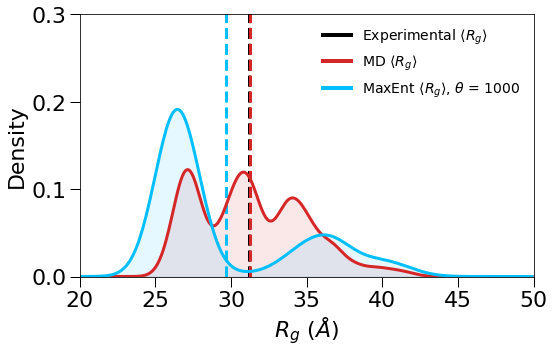

In [35]:
# Define data
simulations = "8"
theta = 1000

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[35000:40000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_wopt_theta_{}_HOIP_extended.txt".format(simulations, theta))
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta))

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta)], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

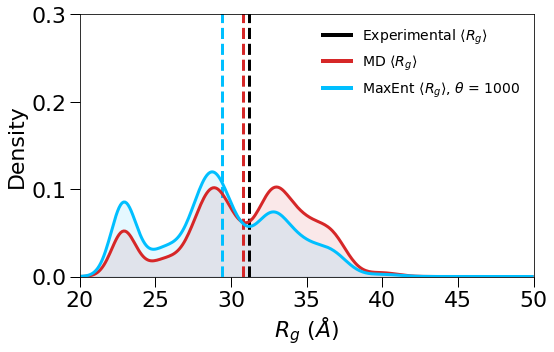

In [37]:
# Define data
simulations = "9"
theta = 1000

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[40000:45000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_wopt_theta_{}_HOIP_extended.txt".format(simulations, theta))
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta))

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta)], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

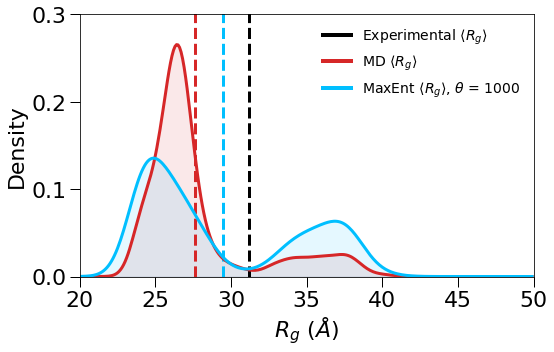

In [39]:
# Define data
simulations = "10"
theta = 1000

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[45000:-1]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_wopt_theta_{}_HOIP_extended.txt".format(simulations, theta))
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta))

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta)], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)

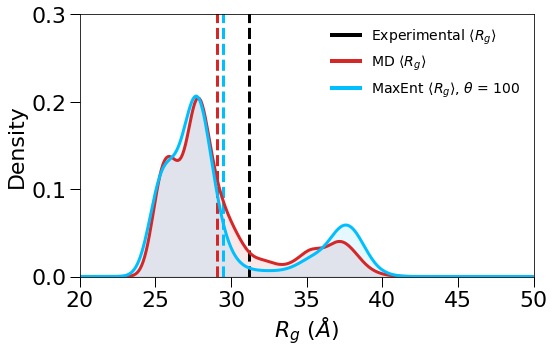

In [29]:
# Define data
simulations = "4_5"
theta = 100

rgyr = np.loadtxt("MD_ensemble/MD_collective_variables/rgyr.txt")[15000:25000]
weights = np.loadtxt("MaxEnt_ensemble/combinations/simulations_{}/output.files/bioen_wopt_theta_{}_HOIP_extended.txt".format(simulations, theta))
avg_md = rgyr.mean()
avg_maxent = sum(rgyr * weights)

# Plot
tick_params = dict(labelsize=22, length=10, width=1)
marker_style = dict(c='tab:blue', marker='o', s=25, alpha=0.4, edgecolors="k")

fs = 22
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot(111)

density = stats.kde.gaussian_kde(rgyr)
density_weighted = stats.kde.gaussian_kde(rgyr, weights=weights)
x = np.arange(20, 50, .1)

ax.vlines(31.2, 0, 1, linestyle="--", linewidth=3, color="k", label=r"Experimental $\langle R_g \rangle$")
ax.vlines(avg_md - 0.1, 0, 1, linestyle="--", linewidth=3, color="tab:red", label=r"MD $\langle R_g \rangle$")  # Added/subtracted 0.1 for visualisation purposes
ax.vlines(avg_maxent + 0.1, 0, 1, linestyle="--", linewidth=3, color="deepskyblue", label=r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta))

ax.plot(x, density(x),
          color="tab:red",
          linewidth=3)
ax.fill_between(x, density(x), color="tab:red", alpha=0.1)

ax.plot(x, density_weighted(x),
          color="deepskyblue",
          linewidth=3)
ax.fill_between(x, density_weighted(x), color="deepskyblue", alpha=0.1)

ax.set_xlim(20, 50)
ax.set_ylim(0, 0.3)

ax.legend(fontsize=14, frameon=False)

custom_lines = [Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="deepskyblue", lw=4)]

ax.legend(custom_lines, [r"Experimental $\langle R_g \rangle$", r"MD $\langle R_g \rangle$", r"MaxEnt $\langle R_g \rangle$, $\theta$ = {}".format(theta)], fontsize=14, frameon=False)

ax.set_xticks([20, 25, 30, 35, 40, 45, 50])

ax.tick_params(**tick_params)

ax.set_xlabel("$R_g$ ($\AA$)", fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)